# Problem Definition
Merchants sometimes run big promotions (e.g., discounts or cash coupons) on particular dates (e.g., Boxing-day Sales, "Black Friday" or "Double 11 (Nov 11th)”, in order to attract a large number of new buyers. Unfortunately, many of the attracted buyers are one-time deal hunters, and these promotions may have little long lasting impact on sales. To alleviate this problem, it is important for merchants to identify who can be converted into repeated buyers. By targeting on these potential loyal customers, merchants can greatly reduce the promotion cost and enhance the return on investment (ROI). It is well known that in the field of online advertising, customer targeting is extremely challenging, especially for fresh buyers. However, with the long-term user behavior log accumulated by Tmall.com, we may be able to solve this [problem](https://tianchi.aliyun.com/competition/entrance/231576/information?t=1704557398174).



We provide a set of merchants and their corresponding new buyers acquired during the promotion on the "Double 11" day. **Your task is to predict which new buyers for given merchants will become loyal customers in the future**. In other words, you need to predict the probability that these new buyers would purchase items from the same merchants again within 6 months.

* **activity_log** item_id:category_id:brand_id:time_stamp:action_type
* action_type {0, 1, 2, 3}, 0 is for click, 1 is for add-to-cart, 2 is for purchase and 3 is for add-to-favourite.
* **label** {0, 1, -1, NULL}. ' 1' denotes ' user_id' is a repeat buyer for ' merchant_id' , while ' 0' is the opposite. ' -1' represents that ' user_id' is not a new customer of the given merchant, thus out of our prediction

Current baseline is **~0.704**

# Ingest
- Extending original dataset by seller and user stats
- Splitting all features on before and after Nov 11th
- Turning top 100 purchased categories to wide format followed by applying SVD (top 100 for now, fails due to lack of memory for greater value)

In [1]:
import numpy as np
import pandas as pd
import pyarrow.csv as pw
from embedding_encoder import EmbeddingEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


ee=EmbeddingEncoder(task='classification')

user_info = pd.read_csv("data/data_format1/user_info_format1.csv")
user_log = pw.read_csv("data/data_format1/user_log_format1.csv").to_pandas()

temp = (
    user_log.loc[user_log["action_type"].isin([2, 1, 3])]
    .assign(
        flag=lambda x: x["time_stamp"].apply(
            lambda y: "On_d11" if y >= 1111 else "Before_d11"
        )
    )
    .groupby(["user_id", "seller_id", "action_type", "flag"], as_index=False)
    .agg(
        item_cnt=("item_id", "count"),
        brand_cnt=("brand_id", "count"),
        cat_cnt=("cat_id", "nunique"),
        cat_concat=("cat_id", lambda x: " ".join(x.astype(str))),
        # brand_concat=("brand_id", lambda x: " ".join(x.astype(str))),
        day_cnt=("time_stamp", "nunique"),
    )
    .pivot(
        columns=["action_type", "flag"],
        index=["user_id", "seller_id"],
        values=["cat_cnt", "day_cnt", "item_cnt", "brand_cnt","cat_concat"],
    )
    .reset_index()
)


temp.columns = temp.columns.map("{0[2]}_{0[1]}_{0[0]}".format)
temp = temp.rename(columns={"__user_id": "user_id", "__seller_id": "merchant_id"})
cols = [x for x in temp.columns if "concat" not in x]
temp[cols] = temp[cols].fillna(0).astype(np.int32)

# user_log
seller_stats = (
    user_log
    .loc[user_log['action_type'].isin([1,2,3])]
    .assign(flag=user_log['time_stamp'].apply(lambda x: "On_d11" if x>=1111 else "After"))
    .groupby(['seller_id','action_type','flag'],as_index=False)
    .agg(
        merch_user_cnt=('user_id','nunique'),
        merch_item_cnt=('item_id','nunique'),
        merch_cat_cnt=('cat_id','nunique')
    )
    .pivot(index='seller_id',columns=['action_type','flag'],values=['merch_user_cnt','merch_item_cnt','merch_cat_cnt'])
    .reset_index()
)
seller_stats.columns = seller_stats.columns.map("{0[2]}_{0[1]}_{0[0]}".format)
seller_stats = seller_stats.rename(columns={"__seller_id": "merchant_id"})


# user_log
user_stats = (
    user_log
    .loc[user_log['action_type'].isin([1,2,3])]
    .assign(flag=user_log['time_stamp'].apply(lambda x: "On_d11" if x>=1111 else "After"))
    .groupby(['user_id','action_type','flag'],as_index=False)
    .agg(
        user_merch_cnt=('seller_id','nunique'),
        user_item_cnt=('item_id','nunique'),
        user_cat_cnt=('cat_id','nunique'),
        user_day_cnt=('time_stamp','nunique')
    )
    .pivot(index='user_id',columns=['action_type','flag'],values=['user_cat_cnt','user_merch_cnt','user_item_cnt','user_day_cnt'])
    .reset_index()
)
user_stats.columns = user_stats.columns.map("{0[2]}_{0[1]}_{0[0]}".format)
user_stats = user_stats.rename(columns={"__user_id": "user_id"})

categories = (
    user_log
     .loc[user_log['action_type']==2]
     .groupby('cat_id',as_index=False)['action_type']
     .agg(
        {'cnt':'count'}
     )
     .sort_values('cnt',ascending=False)
     .head(100)
    ['cat_id']
).tolist()

user_log['top100_cat_id'] = user_log['cat_id'].apply(lambda x: x if x in categories  else 0000)
user_log.loc[user_log['top100_cat_id']==0]

cat_svd=(
    user_log
    .loc[user_log['action_type']==2]
    .groupby(['user_id','seller_id','top100_cat_id'],as_index=False)['action_type']
    .agg({'cnt':'count'})
    .pivot_table(columns='top100_cat_id',values='cnt',index=['user_id','seller_id'])
    .fillna(0)
    .astype(np.int32)
    .reset_index()
    .rename(columns={"seller_id":"merchant_id"})
    
)
cat_svd.columns = cat_svd.columns.map(str)

def prepare_data(data):
    data = (data.merge(user_info, how="left")
            .merge(temp, how="left")
            .merge(seller_stats,how='left', left_on='merchant_id',right_on='merchant_id')
            .merge(user_stats,how='left', left_on='user_id', right_on = 'user_id')
            .merge(cat_svd,how='left')
           )
    return data

In [24]:
train = pd.read_csv(
    "/home/orazs/competitions/tianchi/data/data_format1/train_format1.csv"
)
train = prepare_data(train)
train

,user_id,merchant_id,label,age_range,gender,Before_d11_2_cat_cnt,On_d11_2_cat_cnt,Before_d11_3_cat_cnt,On_d11_3_cat_cnt,Before_d11_1_cat_cnt,...,1467,1505,1528,1553,1577,1591,1604,1611,1644,1661
0,34176,3906,0,6.0,0.0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,34176,121,0,6.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,34176,4356,1,6.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34176,2217,0,6.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,230784,4818,0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260859,359807,4325,0,4.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260860,294527,3971,0,0.0,1.0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
260861,294527,152,0,0.0,1.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
260862,294527,2537,0,0.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from ydata_profiling import ProfileReport

report = ProfileReport(train)
report

# EDA

In [ ]:
import patchworklib as pw
from mizani.formatters import percent_format
from plotnine import *

p = (
    ggplot(
        (
            train.loc[(train.label != -1) & (train.gender != 2)]
            .groupby(["age_range", "gender", "label"], as_index=False)["user_id"]
            .agg({"users": "count"})
            .assign(
                total=lambda x: x.groupby(["age_range", "gender"])["users"].transform(
                    "sum"
                ),
                ratio=lambda x: x["users"] / x["total"],
            )
            .loc[lambda x: x.label == 1]
        ),
        aes("factor(age_range)", "ratio", fill="factor(gender)"),
    )
    + geom_bar(stat="identity", position="dodge")
    + scale_fill_brewer()
    + labs(
        title="Repeated customers ratio by age range and gender",
        x="Age Range",
        y="Ratio (%)",
    )
    + theme_minimal()
    + theme(legend_position="bottom", legend_title=element_blank())
    + scale_y_continuous(labels=percent_format())
)

p2 = (
    ggplot(
        train.melt(
            id_vars=[
                x
                for x in train.columns
                if x not in ["items_cnt", "category_cnt", "brands_cnt", "days_cnt"]
            ]
        ),
        aes("factor(label)", "value"),
    )
    + stat_summary(fun_data="mean_cl_normal", geom="errorbar")
    + facet_grid(". ~ variable")
    + labs(title="Difference per label", x="Repeated", y="#")
)
p3 = (
    ggplot(
        train.melt(
            id_vars=[
                x
                for x in train.columns
                if x not in ["action_0", "action_1", "action_2", "action_3"]
            ]
        ),
        aes("factor(label)", "value"),
    )
    + stat_summary(fun_data="mean_cl_normal", geom="errorbar")
    + facet_grid(". ~ variable")
    + labs(title="Difference per label", x="Repeated", y="#")
)
pw.param["margin"] = 0.5
g = pw.load_ggplot(p, figsize=(2, 2))
g2 = pw.load_ggplot(p2)
g3 = pw.load_ggplot(p3)

g12 = g | (g2 / g3)
g12.savefig()

In [3]:
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE, RandomOverSampler
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import (
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import auc, f1_score, roc_curve,classification_report
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    Normalizer,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    TargetEncoder,
)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    train.drop(["user_id", "label"], axis=1),
    train["label"],
    test_size=0.3,
    stratify=train["label"],
)

In [20]:
concatenated_categories = [x for x in x_train.columns if "concat" in x]
numeric_features = [x for x in x_train.columns if "cnt" in x]

preprocess = ColumnTransformer(
    
    verbose_feature_names_out=False,
    
    transformers=[
        (
            "cat_features",
            Pipeline(steps=[("te", TargetEncoder())
                           ]),
            ["merchant_id", "gender", "age_range"],
        ),
        ("svd",
         Pipeline(steps=[
             ('svd',TruncatedSVD(n_components=5))
         ]),
           cat_svd.columns.tolist()[2:]),
        (
            "numeric_features",
            Pipeline(
                steps=[
                    ("si", SimpleImputer(missing_values=np.nan, strategy="median"))
                ]
            ),
            numeric_features,
        ),
    ],
).set_output(transform="pandas")

rf = xgb.XGBClassifier()

pipe = Pipeline(steps=[("ct", preprocess), 
                       ('pt',PowerTransformer()),
                       # ('pf',PolynomialFeatures(interaction_only=True)),
                       ("rf", rf)])

params = {
    "rf__n_estimators": [250, 300, 350],
    "rf__learning_rate": [0.01, 0.05, 0.1],
    "rf__max_depth": [3, 6, 10],
    "rf__scale_pos_weight": [5,9,15],
}

rsearch = RandomizedSearchCV(
    estimator=pipe, param_distributions=params, scoring="f1_macro"
)
rsearch.fit(x_train, y_train)

scores = cross_validate(
    rsearch.best_estimator_,
    x_train,
    y_train,
    scoring="f1_macro",
    cv=5,
    return_train_score=True,
)
print(
    "Best Score:{0}\nparams:{1}\nAverage: {2}".format(
        rsearch.best_score_, rsearch.best_params_, scores["test_score"].mean()
    )
)


Best Score:0.5257772755730341
params:{'rf__scale_pos_weight': 9, 'rf__n_estimators': 300, 'rf__max_depth': 3, 'rf__learning_rate': 0.01}
Average: 0.5266870550164879


# Validation

In [22]:

y_pred =rsearch.best_estimator_.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print(auc(fpr, tpr))

0.7115768320147727


# HCM

Another trick I found quite handy during the analysis. The idea is to extend train dataset by observations with wrong predictions.

In [ ]:
wrong_predictions = pd.DataFrame(data={}, columns=x_train.columns)
for i in range(len(x_test)):
    if y_pred[i] == 0 and y_test.to_list()[i] == 1:
        # actual default was wrongly labeled as paid-off
        wrong_predictions = wrong_predictions.append(x_test.iloc[[i]])
print("shape before: {0}".format(x_train.shape))
cols = [x for x in wrong_predictions.columns if wrong_predictions[x].dtype=='object' and 'concat' not in x]
wrong_predictions[cols] = wrong_predictions[cols].astype(np.float64)
x_train = pd.concat([x_train, wrong_predictions], axis=0)
y_train = y_train.append(pd.Series([1] * len(wrong_predictions)))
print("shape after: {0}".format(x_train.shape))

In [ ]:
X_test = rsearch.best_estimator_[0].transform(x_test)
from raiwidgets import ErrorAnalysisDashboard

predictions = rsearch.best_estimator_.predict(x_test)
features = rsearch.best_estimator_[0].get_feature_names_out()
ErrorAnalysisDashboard(
    dataset=X_test, true_y=y_test, features=features, pred_y=predictions
)

 # Submission

In [25]:
test = pd.read_csv(
    "/home/orazs/competitions/tianchi/data/data_format1/test_format1.csv"
)
test = prepare_data(test)
test["prob"] = rsearch.best_estimator_.predict_proba(test)[:, 1]
test[["user_id", "merchant_id", "prob"]].to_csv("data/prediction.csv", index=False)

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN
...,...,...,...
261472,228479,3111,NaN
261473,97919,2341,NaN
261474,97919,3971,NaN
261475,32639,3536,NaN



# Evaluation

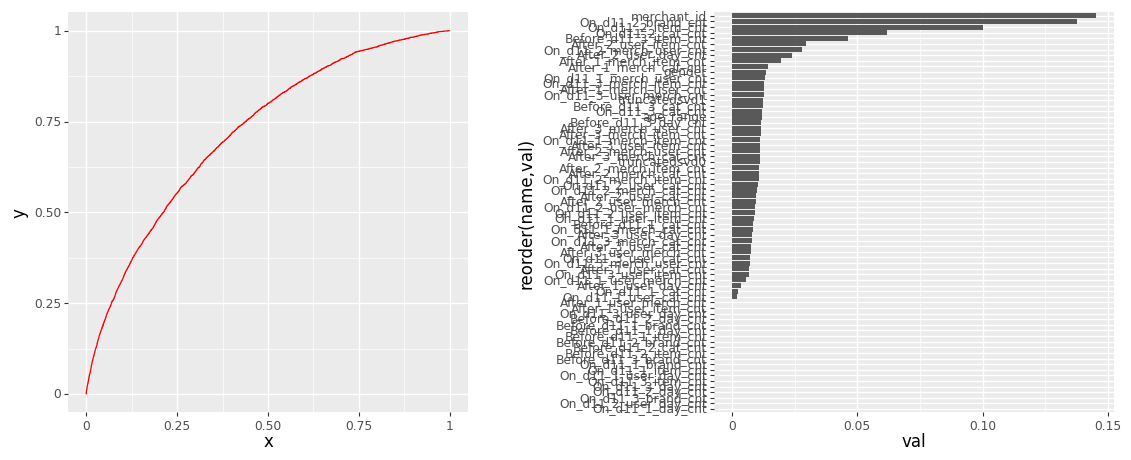

In [26]:
import patchworklib as pwl
from plotnine import *

fi_df = pd.DataFrame(
    data={
        "val": rsearch.best_estimator_[2].feature_importances_,
        "name": rsearch.best_estimator_[1].feature_names_in_,
    }
)
p1 = (
    ggplot(fi_df, aes("reorder(name,val)", "val"))
    + geom_bar(stat="identity")
    + coord_flip()
)

x, y, t = roc_curve(
    y_test, rsearch.best_estimator_.predict_proba(x_test)[:, 1], pos_label=1
)
roc_df = pd.DataFrame(data={"x": x, "y": y})
p = ggplot(roc_df, aes("x", "y")) + geom_line(color="red")

pwl.param["margin"] = 0.5
g = pwl.load_ggplot(p, figsize=(4, 4))
g1 = pwl.load_ggplot(p1, figsize=(4, 4))

g12 = g | g1
g12.savefig()

In [25]:
rsearch.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat_features',
                                                  Pipeline(steps=[('te',
                                                                   TargetEncoder())]),
                                                  ['merchant_id', 'gender',
                                                   'age_range']),
                                                 ('svd',
                                                  Pipeline(steps=[('svd',
                                                                   TruncatedSVD())]),
                                                  ['0', '35', '119', '120',
                                                   '154', '177', '178', '180',
                                                   '184', '229', '247', '252',
                                                   '267', '276', '295', '300',
                                                   '301', '302', '320', '351',
                                                   '369', '384', '387', '389',
                                                   '407', '420'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

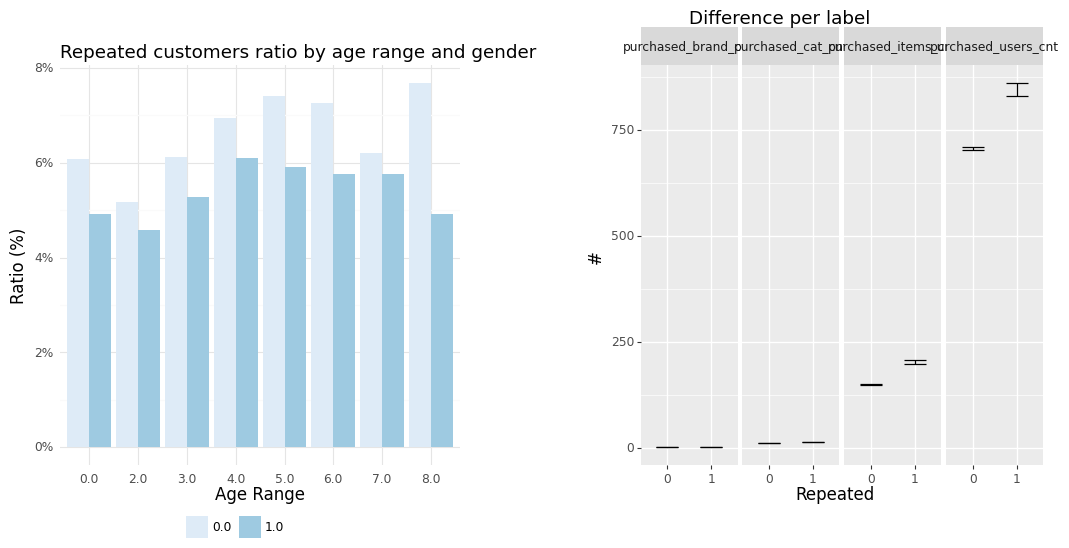

In [12]:
p_1 = (
    ggplot(
        (
            train.loc[(train.label != -1) & (train.gender != 2)]
            .groupby(["age_range", "gender", "label"], as_index=False)["user_id"]
            .agg({"users": "count"})
            .assign(
                total=lambda x: x.groupby(["age_range", "gender"])["users"].transform(
                    "sum"
                ),
                ratio=lambda x: x["users"] / x["total"],
            )
            .loc[lambda x: x.label == 1]
        ),
        aes("factor(age_range)", "ratio", fill="factor(gender)"),
    )
    + geom_bar(stat="identity", position="dodge")
    + scale_fill_brewer()
    + labs(
        title="Repeated customers ratio by age range and gender",
        x="Age Range",
        y="Ratio (%)",
    )
    + theme_minimal()
    + theme(legend_position="bottom", legend_title=element_blank())
    + scale_y_continuous(labels=percent_format())
)

p_2 = (
    ggplot(
        train.melt(
            id_vars=[
                x
                for x in train.columns
                if x
                not in [
                    "purchased_users_cnt",
                    "purchased_items_cnt",
                    "purchased_cat_cnt",
                    "purchased_brand_cnt",
                ]
            ]
        ),
        aes("factor(label)", "value"),
    )
    + stat_summary(fun_data="mean_cl_normal", geom="errorbar")
    + facet_grid(". ~ variable")
    + labs(title="Difference per label", x="Repeated", y="#")
)

g = pw.load_ggplot(p_1, figsize=(4, 4))
g1 = pw.load_ggplot(p_2, figsize=(4, 4))
g12 = g | g1
g12.savefig()